## BAG OF WORDS DATABASE
### KOS blog entries: orig source: dailykos.com 

### Descarga de la colección de textos preprocesada

In [2]:
import os
import classicdb.fetch as fetch

url = "https://sites.google.com/site/xchgdir/public/kos.tar.gz"
classic_home = os.path.join(fetch.get_data_home(), "kos_home")
corpus_root = os.path.join(classic_home, "kos")

In [3]:
print("download and extracting file from " + url)
fetch.download_and_unzip(url, classic_home, "kos.tar.gz")
print("downloaded and extracted to " + classic_home)

download and extracting file from https://sites.google.com/site/xchgdir/public/kos.tar.gz


downloaded and extracted to C:\Users\lmamani\scikit_learn_data\kos_home


### Parseo y carga en memoria

In [4]:
import os

vocabfile = os.path.join(corpus_root, "vocab.kos.txt")
docwordfile = os.path.join(corpus_root, "docword.kos.txt")

with open(vocabfile, 'r') as f:
    vocab = [line.strip() for line in f.readlines()]

bagdicts = []
with open(docwordfile, 'r') as f:
    for line in f.readlines():
        w = line.strip().split()
        if len(w) == 3:
            docid = int(w[0]) - 1
            wordid = int(w[1]) - 1
            wordcount = int(w[2])
            if len(bagdicts) <= docid:
                bagdicts.append({})  # add new dictionary
            dict = bagdicts[docid]
            dict[vocab[wordid]] = wordcount  # add new (vocab[wordid], count) into dictionary
            # dict[wordid] = wordcount  # add new (wordid, count) into dictionary

print(len(vocab), "words in vocabulary")
print(len(bagdicts), "documents")

6906 words in vocabulary
3430 documents


### Conteo de tokens del corpus
- Cada fila representa un documento y está en el orden leído del documento
- Cada columna representa un término y ha sido reordenado (por el Dict)

In [5]:
import numpy as np
from sklearn.feature_extraction import DictVectorizer

vectorizer = DictVectorizer(sparse=False)
count_matrix = vectorizer.fit_transform(bagdicts)
print("cols = frequency by term, row = frequency by file")
print(count_matrix)
print()

for f in range(0, 3):
    print("file #", f, "has", int(np.sum(count_matrix[f])), "terms")
print("...")
print()

print("Some feature terms")
print(vectorizer.get_feature_names()[0:100])

cols = frequency by term, row = frequency by file
[[ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]

file # 0 has 137 terms
file # 1 has 77 terms
file # 2 has 157 terms
...

Some feature terms
['aarp', 'abandon', 'abandoned', 'abandoning', 'abb', 'abc', 'abcs', 'abdullah', 'ability', 'aboard', 'abortion', 'abortions', 'abraham', 'abrams', 'abroad', 'absence', 'absent', 'absentee', 'absolute', 'absolutely', 'abstain', 'absurd', 'abu', 'abuse', 'abuses', 'academy', 'accent', 'accept', 'acceptable', 'acceptance', 'accepted', 'accepting', 'access', 'accident', 'accidentally', 'accidents', 'accomplish', 'accomplished', 'accomplishment', 'account', 'accountability', 'accountable', 'accounting', 'accounts', 'accuracy', 'accurate', 'accurately', 'accusations', 'accused', 'accusing', 'achieve', 'achieved', 'achievements', 'acknowledge', 'acknowled

### Cálculo de matriz TFID

In [6]:
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer()
tfidf = transformer.fit_transform(count_matrix)

print("TFID matrix:", tfidf.shape)
print(tfidf.toarray())
print()

# print("Weights of each feature computed by fit")
# print(transformer.idf_)

TFID matrix: (3430, 6906)
[[ 0.          0.          0.         ...,  0.          0.08710494  0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]



### Clusterización y evaluación de la clusterización
Clasificación de 2 a 50 clústeres, en cada uno se repite 10 veces la clusterización.
- 10, 21, 7, 15 y 9 los #5 clústeres que presentan el mejor s-score
- 2, 3 y 4 clústeres presentan variación mínima en el s-score

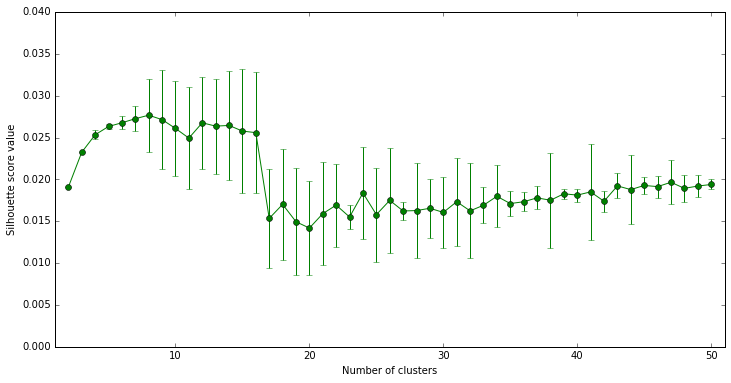

In [15]:
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt

% matplotlib inline

x = []
y = []
yerr = []

for n_clusters in range(2, 51, 1):
    km = KMeans(
        n_clusters=n_clusters,
        init='k-means++',  # or 'random'  
        n_init=1,  # repetition of the process to choose the best
        max_iter=100  # iterations for kmeans
    )
    
    sscore = []
    for i in range(1, 10):
        km.fit(tfidf)
        sscore.append(metrics.silhouette_score(tfidf, km.labels_))
    
    x.append(n_clusters)
    y.append(np.median(sscore))
    yerr.append(np.std(sscore))

plt.figure(figsize=(12, 6))
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score value')
plt.errorbar(x, y, yerr=yerr, fmt='-o', ecolor='g', color='g')
plt.xlim(xmin=1, xmax=51)
plt.ylim(ymin=0, ymax=0.040)
plt.show()

In [16]:
for i, ye in enumerate(yerr):
    print(x[i], "\t", y[i], "\t", yerr[i])

2 	 0.0190743565792 	 0.0
3 	 0.02324056488 	 4.16648616608e-06
4 	 0.0253310745076 	 0.000538742678941
5 	 0.0263202140122 	 0.000266222143283
6 	 0.026769260356 	 0.000770307457046
7 	 0.0272521022281 	 0.00148287319871
8 	 0.0276697535109 	 0.00434488611273
9 	 0.0271413782831 	 0.00594472721928
10 	 0.026090995065 	 0.00567452045779
11 	 0.024934376114 	 0.00607792927016
12 	 0.026763783359 	 0.00550448976143
13 	 0.0263651671887 	 0.00567546722879
14 	 0.0264476247016 	 0.00647462361814
15 	 0.0257732207956 	 0.00741273128293
16 	 0.025586154174 	 0.00723777625177
17 	 0.0153402085248 	 0.00586652450744
18 	 0.0170175070241 	 0.00661247505153
19 	 0.0149415675895 	 0.00636827443661
20 	 0.0141846043254 	 0.00559473526154
21 	 0.0159078107314 	 0.00612846024641
22 	 0.016926964947 	 0.00496403958676
23 	 0.0155094076308 	 0.00141726738741
24 	 0.0183791131525 	 0.00551112767074
25 	 0.015790708479 	 0.00561343369359
26 	 0.0174976446072 	 0.00627563955228
27 	 0.0162267527856 	 0.0

### Más clusters

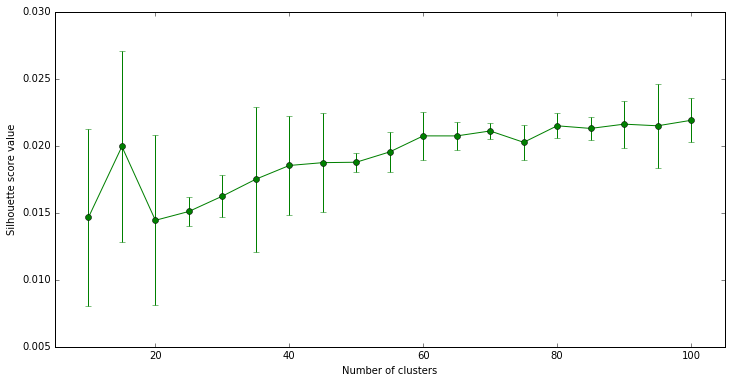

In [22]:
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt

% matplotlib inline

x = []
y = []
yerr = []

for n_clusters in range(10, 105, 5):
    km = KMeans(
        n_clusters=n_clusters,
        init='k-means++',  # or 'random'  
        n_init=1,  # repetition of the process to choose the best
        max_iter=100  # iterations for kmeans
    )
    
    sscore = []
    for i in range(1, 11):
        km.fit(tfidf)
        sscore.append(metrics.silhouette_score(tfidf, km.labels_))
    
    x.append(n_clusters)
    y.append(np.median(sscore))
    yerr.append(np.std(sscore))

plt.figure(figsize=(12, 6))
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score value')
plt.errorbar(x, y, yerr=yerr, fmt='-o', ecolor='g', color='g')
plt.xlim(xmin=5, xmax=105)
# plt.ylim(ymin=0, ymax=0.040)
plt.show()

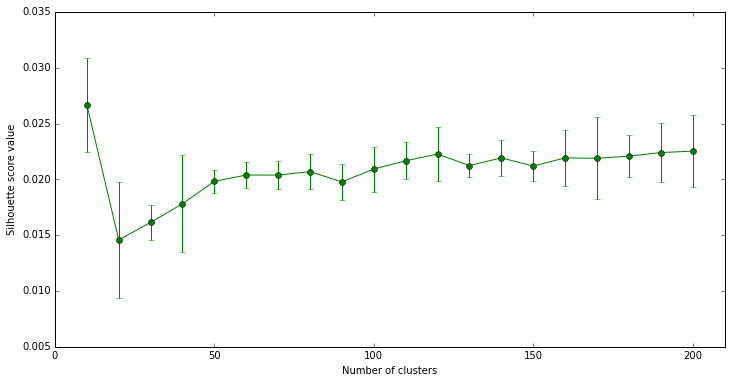

In [23]:
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt

% matplotlib inline

x = []
y = []
yerr = []

for n_clusters in range(10, 210, 10):
    km = KMeans(
        n_clusters=n_clusters,
        init='k-means++',  # or 'random'  
        n_init=1,  # repetition of the process to choose the best
        max_iter=100  # iterations for kmeans
    )
    
    sscore = []
    for i in range(1, 11):
        km.fit(tfidf)
        sscore.append(metrics.silhouette_score(tfidf, km.labels_))
    
    x.append(n_clusters)
    y.append(np.median(sscore))
    yerr.append(np.std(sscore))

plt.figure(figsize=(12, 6))
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score value')
plt.errorbar(x, y, yerr=yerr, fmt='-o', ecolor='g', color='g')
plt.xlim(xmin=0, xmax=210)
# plt.ylim(ymin=0, ymax=0.040)
plt.show()

#### 8 clústers

In [19]:
from sklearn.cluster import KMeans

n_clusters = 8
km = KMeans(
    n_clusters=n_clusters,
    init='k-means++',  # or 'random'  
    n_init=10,  # repetition of the process to choose the best
    max_iter=100  # iterations for kmeans
)

km.fit(tfidf)

print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(n_clusters):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % vectorizer.get_feature_names()[ind], end='')
    print()

Top terms per cluster:
Cluster 0: carson coburn senate specter toomey oklahoma knowles bunning murkowski race
Cluster 1: party house republican democratic elections senate republicans campaign democrats state
Cluster 2: iraq war iraqi military soldiers troops baghdad american killed forces
Cluster 3: dean clark edwards kerry lieberman gephardt primary poll iowa democratic
Cluster 4: november voting account electoral governor vote senate republicans house polls
Cluster 5: bush administration president cheney iraq bushs white war house people
Cluster 6: november account electoral turnout governor duderino parecommend poll polls trouble
Cluster 7: kerry bush poll voters percent general polls campaign president kerrys


#### 7 clústers

In [20]:
from sklearn.cluster import KMeans

n_clusters = 7
km = KMeans(
    n_clusters=n_clusters,
    init='k-means++',  # or 'random'  
    n_init=10,  # repetition of the process to choose the best
    max_iter=100  # iterations for kmeans
)

km.fit(tfidf)

print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(n_clusters):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % vectorizer.get_feature_names()[ind], end='')
    print()

Top terms per cluster:
Cluster 0: party senate house republican elections democratic campaign race democrats republicans
Cluster 1: dean clark edwards kerry lieberman gephardt primary poll iowa democratic
Cluster 2: kerry bush poll percent voters polls general results nader polling
Cluster 3: november account electoral turnout governor parecommend duderino poll polls trouble
Cluster 4: bush administration president cheney kerry bushs iraq war campaign white
Cluster 5: november voting account electoral governor vote senate republicans house polls
Cluster 6: iraq war iraqi military bush troops soldiers baghdad american killed


#### 9 clústers

In [21]:
from sklearn.cluster import KMeans

n_clusters = 9
km = KMeans(
    n_clusters=n_clusters,
    init='k-means++',  # or 'random'  
    n_init=10,  # repetition of the process to choose the best
    max_iter=100  # iterations for kmeans
)

km.fit(tfidf)

print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(n_clusters):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % vectorizer.get_feature_names()[ind], end='')
    print()

Top terms per cluster:
Cluster 0: million donors money raised campaign candidates fundraising dkos dnc dozen
Cluster 1: november account electoral turnout governor parecommend duderino poll polls trouble
Cluster 2: senate house elections republican race seat district delay party gop
Cluster 3: bush people general party time media republicans campaign president democratic
Cluster 4: kerry bush poll percent voters polls general nader results polling
Cluster 5: dean clark edwards kerry lieberman gephardt primary poll iowa democratic
Cluster 6: november voting account electoral governor vote senate republicans house polls
Cluster 7: iraq bush war administration iraqi military american troops president intelligence
Cluster 8: kerry cheney bush john president campaign kerrys general news debate


### Dendogram 

In [1]:
% matplotlib inline

from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import ward, dendrogram

dist = 1 - cosine_similarity(tfidf)
linkage_matrix = ward(dist)

fig, ax = plt.subplots(figsize=(8, 30))
ax = dendrogram(linkage_matrix, orientation="right")
plt.tick_params(
    axis='x',  # changes apply to the x-axis
    which='both',  # both major and minor ticks are affected
    bottom='off',  # ticks along the bottom edge are off
    top='off',  # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout()  #show plot with tight layout